In [235]:
import emcee
import numpy as np
import pymc3 as pm
import pandas as pd
import matplotlib.pyplot as plt

WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


In [2]:
def log_prior(theta): 

    s = theta

    # if np.sum(f0) < 0 or np.sum(f0) > 1: 
    #   return -np.inf 

    return 0 

def log_likelihood(theta, t, f):

    
    expression = s - np.sum(f*s)
    return expression * t 

def log_posterior(theta, t, f): 
    s = theta
    return log_prior(theta) + log_likelihood(theta, t, f) 


                                    BC     5    10   25   40  45
0    GGGAGACCGCCGCGGG_AGACGACGGGTATTAC  1682  1101  416  112  41
1    TTATGAAGTAGTTGTA_AATTTTTTTGCCATTC   463   169   50    3   7
2    ATACAATCATTCATAG_CCCGTGAGCTGAGCCG  1375   322  148  120  36
3    GGGTAATCACGCCGAA_GGCAACTAATAATATA   639   256  151   64  31
4    TAGAACCGGTTAAAAA_TGGTAGCTGGACGACA   917   231   48    5  15
..                                 ...   ...   ...  ...  ...  ..
718  CCAAACGCCGTACTAT_CGTCTAGCATAAAGCA   231   106   21    2   0
719  ACCGCCTGGTCACCAG_TTCGTTACTGCCGGGG   278   111    9    5   0
720  TACAACGGATTGGGAA_TTCACATCTGGTACCA   833   181   89   43  47
721  ACGCACCAAGCCGGGA_CCGGGCGATCCACGAA  2916  1559  334   98  47
722  AAGCCTAAATCGTGTG_CTATAGGCGGCGCATC    76     2   15    0   0

[723 rows x 6 columns]
(723, 5)


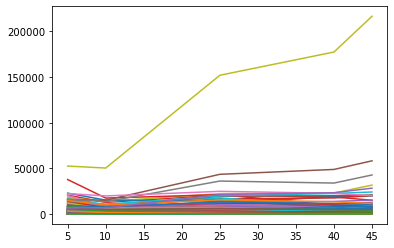

In [227]:
df = pd.read_csv('./filtered_counts_ypd_temp_30.txt', delimiter = "\t")
print(df)

t = np.array(df.columns[1:])
t = [int(i) for i in t]
n = df.loc[:,df.columns[1:]].to_numpy()
#f = df['5','10','25','40','45'] #frequenccy

for i in range(len(n)):
    plt.plot(t,n[i]);
    
plt.show()

In [238]:
z = [np.sum(n[i,:]) for i in range(len(n))]
result = np.where(z == np.max(z))
print(result)
#array element where max counts is 
#this is to define a reference lineage

g = np.zeros(np.shape(n.T))
for i in range(len(n[0,:])):
    g[i] = n[:,i]/np.sum(n[:,i]) 

print(np.shape(g.T))
#frequency calculation where take the sum of each column
#and divide each element by the sum 

#array element where max counts is 
#this is to define a reference lineage

(array([668]),)
(723, 5)


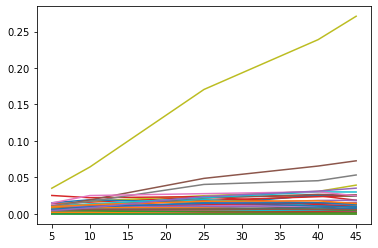

In [230]:
g = g.T
for i in range(len(g)):
    plt.plot(t,g[i]);
#frequencies
plt.show()

In [153]:
s_max = np.max(f[:,4])
s = f[:,4]/s_max
#print(np.sum(s*f[:,4]))

s = 1 / np.trapz()
print(f[:,4]/np.linalg.norm(f[:,4]))
#print(np.exp(s - np.sum(s*f[:,4]) * 45))

[6.81077138e-03 5.63259339e-03 1.00177887e-02 1.51283828e-02
 6.86869354e-03 9.72917380e-02 0.00000000e+00 9.21454994e-02
 9.41332472e-03 9.11738941e-02 1.69144013e-04 2.81504501e-02
 4.02963354e-03 4.36723207e-03 3.97532875e-02 1.07345830e-02
 0.00000000e+00 0.00000000e+00 2.71678657e-02 6.26538767e-02
 6.78224226e-04 0.00000000e+00 5.98733430e-03 8.48259984e-03
 7.42076083e-03 1.64254304e-03 9.86039117e-03 0.00000000e+00
 7.70742440e-02 2.03924821e-02 2.79623434e-02 4.67134752e-02
 2.89008005e-02 1.14724198e-01 5.91670478e-02 1.08785792e-02
 4.44036754e-03 1.13370198e-02 0.00000000e+00 0.00000000e+00
 2.04626599e-02 8.07094872e-02 6.54897848e-02 9.54115812e-02
 0.00000000e+00 1.55769773e-02 2.41886225e-03 7.78092003e-03
 1.19614913e-02 1.08967141e-03 2.06297427e-02 1.80669075e-03
 1.62065187e-01 0.00000000e+00 0.00000000e+00 4.22475030e-03
 1.56410699e-03 0.00000000e+00 1.02317405e-02 0.00000000e+00
 0.00000000e+00 1.21709746e-03 3.71438677e-02 9.25805958e-03
 6.44236084e-03 3.246048

In [294]:
fitness_model = pm.Model()
times = np.array(t)
time = times.reshape([-1, 5])
N = len(n)
traj = g.T

with fitness_model:
    s = pm.Flat("s", shape = (N, 1))
    f0 = pm.HalfFlat("f0", shape = (N, 1))
    f = f0 * pm.math.exp(s * time) / pm.math.sum(f0 * pm.math.exp(s * time),  axis = 0)
    
    f_obs = pm.Poisson("f_obs", mu = f, observed = traj)

In [295]:
map_estimate = pm.find_MAP(model=fitness_model)

0.0


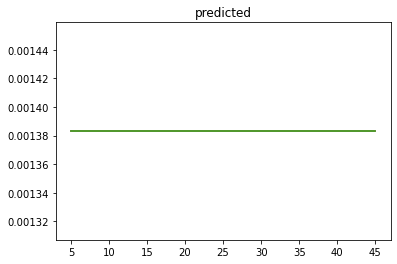

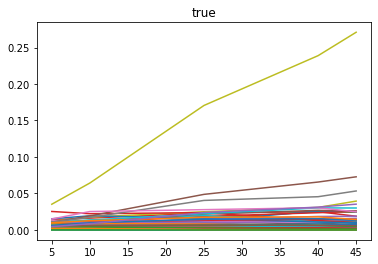

In [296]:
f_pred = map_estimate["f0"] * np.exp(map_estimate["s"] * times)
print(np.max(map_estimate["s"]))
f_pred /= np.sum(f_pred, axis = 0)

plt.figure()
plt.plot(times, f_pred.T)
#plt.ylim(1e-10,1)
plt.title("predicted")

plt.figure()
plt.plot(times, traj.T)
#plt.ylim(1e-10,1)
plt.title("true")
plt.show()

In [ ]:
ndim = 1
nwalkers = 50
nsteps = 1000

ls_result = [0,0] #placeholder
gaussian_ball = 1e-5 * np.random.randn(nwalkers, ndim)
starting_positions = (1 + gaussian_ball) * ls_result

# set up the sampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, 
                                args=(t, f))

%time sampler.run_mcmc(starting_positions, nsteps)
print('Done');

In [25]:
def single_step(f, s, dt):
    """
    Performs a single step of fitness trajectories

    Parameters:
        f: lineage frequencies
        s: lineage fitnesses
        dt: the time step
    Returns:
        f_new: lineage frequencies after time step dt
    """
    s_bar = np.sum(f * s)
    df = f * (s - s_bar) * dt
    f_new = f + df
    return f_new

def create_trajectories(f0, s, num_gens, dt):
    """
    Simulates lineage trajectores given initial frequency and fitnesses

    Parameters:
        f0: initial lineage frequencies
        s: lineage fitnesses
        num_gens: number of generations to simulate
        dt: discretized time step for forward integration
    """
    num_steps = int(np.ceil(num_gens / dt))
    f_traj = np.zeros([num_steps + 1, len(f0)])
    print(len(f0))
    print(np.shape(f_traj[0]))
    print(f_traj[0])
    
    f_traj[0] = f0
    
    for i in range(num_steps):
        f_traj[i+1] = single_step(f_traj[i], s, dt)
    return f_traj

In [27]:
create_trajectories(np.linspace(0,100,100),np.linspace(0,1,100),1000,0.01)

100
(100,)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


/var/folders/8x/l7tc3j9d19qfjtn11qtw1lxw0000gn/T/ipykernel_64361/1773663555.py:13: RuntimeWarning: overflow encountered in multiply
  df = f * (s - s_bar) * dt
/var/folders/8x/l7tc3j9d19qfjtn11qtw1lxw0000gn/T/ipykernel_64361/1773663555.py:13: RuntimeWarning: invalid value encountered in multiply
  df = f * (s - s_bar) * dt


array([[ 0.00000000e+00,  1.01010101e+00,  2.02020202e+00, ...,
         9.79797980e+01,  9.89898990e+01,  1.00000000e+02],
       [ 0.00000000e+00, -3.28298813e+01, -6.56595585e+01, ...,
        -3.18354838e+03, -3.21635847e+03, -3.24916835e+03],
       [ 0.00000000e+00, -3.57717240e+04, -7.15432322e+04, ...,
        -3.46885285e+06, -3.50460365e+06, -3.54035423e+06],
       ...,
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan],
       [            nan,             nan,             nan, ...,
                    nan,             nan,             nan]])